In [3]:
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
import random 
import pickle
import os
import shutil
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV 
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error, make_scorer


In [3]:
# this will play a sound once the cell has finished running
from IPython.display import Audio
sound_file = 'sound/badaboing.wav'

notify=Audio(filename=sound_file, autoplay=True)

In [2]:
# Load dataset with velocity values
vdata = sc.read_h5ad("velocity_adata.h5ad")

In [3]:
# Scale Ms and velocity layer with zero mean and unit variance 
    # sc.pp.scale adds most recent mean and std as variables to var

sc.pp.scale(vdata, layer='Ms')
sc.pp.scale(vdata, layer='velocity')

In [10]:
# Velocity genes
# No Ccl5 included..

velocity_genes = vdata.var.index[vdata.var['velocity_genes'] == True].tolist()

transcription8 = ['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']



In [40]:
velocity_genes.tolist().index('Mylip')


305

In [47]:
predictors = ['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']
X = vdata[:, predictors].layers['Ms']

In [54]:
sys.getsizeof(vdata[:, predictors].layers['Ms'])

128

In [55]:
sys.getsizeof(vdata[:, 'Ttk'].layers['velocity'])

128

In [7]:
# load 160 transcriptionfactors
open_file = open('data/transcriptionfactors160.pkl', "rb")
transcription160 = pickle.load(open_file)
open_file.close()

In [8]:
# remove factors not available in vdata.var_names
for x in  ['Junb', 'mt-Nd1', 'Fgl2', 'mt-Co1', 'mt-Nd4', 'Rraga', 'mt-Nd2']:
    if x in transcription160:
        transcription160.remove(x)

In [9]:
def proportion(y, y_pred):
    return np.mean(np.log(abs(y_pred-y)/abs(y)))

In [10]:
def generating_regressions(model, predictors, targets, n_splits, name):

    path = 'data/'+name
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)

    for g in targets:
        
        coefs = pd.DataFrame()

        # target
        t = [g]

        # train and test set
        X, y = vdata[:, predictors].layers['Ms'], vdata[:, t].layers['velocity']

        # prepare cross validation, data shuffled before split into batches
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

        # I could define my own scorer object; since error, want to minimize it -> the smaller the values the better. 
        s = cross_validate(model, X, y, cv=cv, scoring = {'r2': 'r2', 'neg_mean_squared_error':'neg_mean_squared_error', 'proportion': make_scorer(proportion)}, return_train_score=True, return_estimator=True)

        for x in s['estimator']:
            coefs['predictors'], coefs['coefficients'], coefs['target']= predictors, x.coef_[0], t*len(predictors)
        
        #store results for each gene at the end of the loop before going on to the next gene. 

        # removing unnecessary fit and score times
        s.pop('fit_time', None)
        s.pop('score_time',None)

        scores = pd.DataFrame.from_dict(s)
        scores['target'] = t*n_splits
        
        scores.to_pickle(path+'/'+g+'Scores.pkl')
        coefs.to_pickle(path+'/'+g+'Coefs.pkl')
        
    return path

I would like for this to run through, but it keeps getting killed before. In Jupyter the kernel keeps restarting and in the terminal it just sais killed. 

In [8]:
# recover files. 
path = './linear160'

scores = pd.DataFrame()
coefs = pd.DataFrame()

for (dirpath, dirnames, filenames) in os.walk(path):
    print(filenames)
    for name in filenames:
        with open(path+'/'+name, 'rb') as f:
            df = pickle.load(f)
        # diff between score and coefs. find out. 
        if 'Scores' in name:
            scores = pd.concat([scores, df])
        elif 'Coefs' in name:
            coefs = pd.concat([coefs, df])
        else: print(name)



['Mrpl15Scores.pkl', 'Mrpl15Coefs.pkl', 'Mybl1Scores.pkl', 'Mybl1Coefs.pkl', 'Mcm3Scores.pkl', 'Mcm3Coefs.pkl', 'Smap1Scores.pkl', 'Smap1Coefs.pkl', 'Prim2Scores.pkl', 'Prim2Coefs.pkl', 'Rev1Scores.pkl', 'Rev1Coefs.pkl', 'Aff3Scores.pkl', 'Aff3Coefs.pkl', 'Fhl2Scores.pkl', 'Fhl2Coefs.pkl', 'Nab1Scores.pkl', 'Nab1Coefs.pkl', '1700019D03RikScores.pkl', '1700019D03RikCoefs.pkl', 'Stk17bScores.pkl', 'Stk17bCoefs.pkl', 'Wdr12Scores.pkl', 'Wdr12Coefs.pkl', 'Ikzf2Scores.pkl', 'Ikzf2Coefs.pkl', 'Bard1Scores.pkl', 'Bard1Coefs.pkl', 'PecrScores.pkl', 'PecrCoefs.pkl', 'NclScores.pkl', 'NclCoefs.pkl', 'HjurpScores.pkl', 'HjurpCoefs.pkl', 'PaskScores.pkl', 'PaskCoefs.pkl', 'Pdcd1Scores.pkl', 'Pdcd1Coefs.pkl', 'Bcl2Scores.pkl', 'Bcl2Coefs.pkl', 'Actr3Scores.pkl', 'Actr3Coefs.pkl', 'Tmem163Scores.pkl', 'Tmem163Coefs.pkl', 'Zranb3Scores.pkl', 'Zranb3Coefs.pkl', 'Mcm6Scores.pkl', 'Mcm6Coefs.pkl', 'Cd55Scores.pkl', 'Cd55Coefs.pkl', 'Dyrk3Scores.pkl', 'Dyrk3Coefs.pkl', 'IkbkeScores.pkl', 'IkbkeCoefs.pkl'

In [10]:
scores

,estimator,test_r2,train_r2,test_neg_mean_squared_error,train_neg_mean_squared_error,test_proportion,train_proportion,target
0,LinearRegression(),0.217593,0.217910,-0.852493,-0.774070,-0.053228,-0.051912,Mrpl15
1,LinearRegression(),0.215769,0.218777,-0.758565,-0.783995,-0.072167,-0.050972,Mrpl15
2,LinearRegression(),0.213166,0.219032,-0.708356,-0.789409,-0.003588,-0.059168,Mrpl15
3,LinearRegression(),0.173296,0.223257,-0.775271,-0.782051,-0.023435,-0.059516,Mrpl15
4,LinearRegression(),0.214438,0.218987,-0.824545,-0.776635,-0.048081,-0.060846,Mrpl15
...,...,...,...,...,...,...,...,...
5,LinearRegression(),0.604460,0.591539,-0.405958,-0.407230,-0.401877,-0.375668,Erdr1
6,LinearRegression(),0.608325,0.591011,-0.405212,-0.407356,-0.409564,-0.367290,Erdr1
7,LinearRegression(),0.593695,0.592771,-0.391349,-0.408850,-0.373567,-0.370174,Erdr1
8,LinearRegression(),0.549704,0.597355,-0.435753,-0.404028,-0.290597,-0.381290,Erdr1


In [11]:
coefs.to_pickle('linearCoefs160.pkl')
scores.to_pickle('linearScores160.pkl')

In [1]:
# Dataset predicting velocity genes, with 8 coefficients from 10 fold cross validation
predictors = ['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']
targets = velocity_genes
model = Lasso(alpha=0.000013)

dd, d = generating_regressions(model, predictors, targets, 10, 'lasso000013')
#d.to_pickle('lasso0_01Regression8.pkl')
#dd.to_pickle('lasso0_01RegressionScores8.pkl')
notify

NameError: name 'velocity_genes' is not defined

In [ ]:
d.to_pickle('lasso0_000013Regression8.pkl')
dd.to_pickle('lasso0_000013RegressionScores8.pkl')

# Cross validation - Lasso regression
Plot coefficients against alphas for example.

In [18]:
lasso = Lasso(max_iter=10000, normalize=True)
alphas = 10**np.linspace(-1,-6,50)*0.5


coefs = []
        # target
t = ['Rasgrp2']

        # train and test set
X, y = vdata[:, transcription8].layers['Ms'], vdata[:, t].layers['velocity']


for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)
    
np.shape(coefs)

(50, 8)

Text(0.5, 1.0, "['Rasgrp2']")

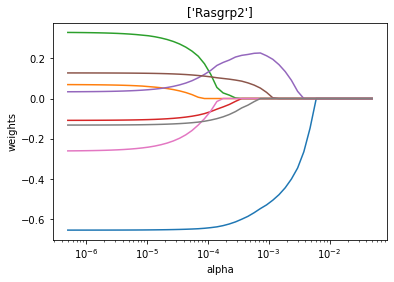

In [19]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
ax.set_title(str(t))

### Plot coefficients against alphas for all velocity genes

In [ ]:
lasso = Lasso(max_iter=10000, normalize=True)
alphas = 10**np.linspace(-1,-6,50)*0.5

targets = velocity_genes
predictors = transcription8

all_coefs = {'alpha': alphas}

for g in targets:

    coefs = []
    # target
    t = [g]

    # train and test set
    X, y = vdata[:, predictors].layers['Ms'], vdata[:, t].layers['velocity']


    for a in alphas:
        lasso.set_params(alpha=a)
        lasso.fit(X, y)
        coefs.append(lasso.coef_)
      
    
    all_coefs[g]=coefs
    #a = pd.DataFrame(np.hstack((alphas.reshape(-1,1), coefs, len(alphas)*[t])), columns=['alpha']+predictors+['target'])
    #all_coefs = all_coefs.append([all_coefs, a])
    
np.shape(coefs)

In [ ]:
from cycler import cycler

In [ ]:
ax = plt.gca()
a = all_coefs['alpha']
#ax.set_color_cycle(['b', 'g', 'r', 'c', 'm', 'y', 'lightgreen', 'orange'])

for t in targets: 
    
    c = all_coefs[t][t]
    
    ax.plot(a, c)
    ax.set_xscale('log')
    ax.set_prop_cycle(cycler(color=['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'purple']))
    plt.axis('tight')
    plt.xlabel('alpha')
    plt.ylabel('weights')
    ax.set_title(str(t))

# Look at finding the best alpha for ridge and lasso. Mainly lasso.

this is based on: https://www.kaggle.com/floser/aw6-the-lasso-cross-validated

In [ ]:
alpha = []

for t in velocity_genes:
    
    target= t
    lasso = Lasso()

    X, y = vdata[:, transcription8].layers['Ms'], vdata[:, target].layers['velocity']

    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

    lassocv = LassoCV(alphas=None, cv=5, max_iter=100000, normalize=True)
    lassocv.fit(X_train, y_train)
    lasso.set_params(alpha=lassocv.alpha_)
    #print("Alpha=", lassocv.alpha_)
    lasso.fit(X_train, y_train)
    #print("mse = ",mean_squared_error(y_test, lasso.predict(X_test)))
    #print("best model coefficients:")
    #pd.Series(lasso.coef_, index=X.columns)
    alpha+= [lassocv.alpha_]

In [ ]:
pd.DataFrame(alpha).to_pickle('best_alphas_lasso.pkl')

In [5]:
# since this takes forever to run, I save the ones from the last one that finally ran through

open_file = open('best_alphas_lasso.pkl', "rb")
alpha = pickle.load(open_file)
open_file.close()

In [6]:
np.mean(pd.DataFrame(alpha))

0    0.000013
dtype: float64

(array([749., 163.,  72.,  30.,  32.,  16.,  15.,   6.,   6.,   6.,   4.,
          4.,   0.,   0.,   2.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([6.78096006e-07, 1.04815060e-05, 2.02849161e-05, 3.00883261e-05,
        3.98917362e-05, 4.96951462e-05, 5.94985562e-05, 6.93019663e-05,
        7.91053763e-05, 8.89087863e-05, 9.87121964e-05, 1.08515606e-04,
        1.18319016e-04, 1.28122426e-04, 1.37925837e-04, 1.47729247e-04,
        1.57532657e-04, 1.67336067e-04, 1.77139477e-04, 1.86942887e-04,
        1.96746297e-04, 2.06549707e-04, 2.16353117e-04, 2.26156527e-04,
        2.35959937e-04, 2.45763347e-04, 2.55566757e-04, 2.65370167e-04,
        2.75173577e-04, 2.84976987e-04, 2.94780397e-04]),
 <BarContainer object of 30 artists>)

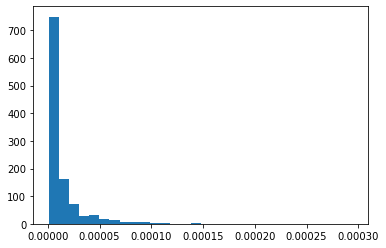

In [7]:
plt.hist(alpha, bins=30)

# Cross validation - Ridge
Cross validation with lasso regression; finding the best alpha

In [ ]:
ridge = Ridge(max_iter=10000, normalize=True)
alphas = 10**np.linspace(5,-4,50)*0.5

predictors = ['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']

coefs = []
        # target
t = ['Tox']

        # train and test set
X, y = vdata[:, predictors].layers['Ms'], vdata[:, t].layers['velocity']


for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_.reshape(8,))
    
np.shape(coefs)

In [ ]:
coefs[1].reshape(8,)

In [ ]:
np.shape(ridge.coef_.reshape(50,8))

In [ ]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
ax.set_title(str(t))

### Find best alpha for ridge regression
This is not running through. It keeps getting killed. 

In [ ]:
alpha = []
alphas = 10**np.linspace(5,-4,50)*0.5

for t in velocity_genes:
    
    target= t
    ridge = Ridge()

    X, y = vdata[:, transcription8].layers['Ms'], vdata[:, target].layers['velocity']

    X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

    ridgecv = RidgeCV(alphas=alphas, cv=5, normalize=True)
    ridgecv.fit(X_train, y_train)
    ridge.set_params(alpha=ridgecv.alpha_)
    #print("Alpha=", ridgecv.alpha_)
    ridge.fit(X_train, y_train)
    #print("mse = ",mean_squared_error(y_test, ridge.predict(X_test)))
    #print("best model coefficients:")
    #pd.Series(ridge.coef_, index=X.columns)
    alpha+= [ridgecv.alpha_]

In [ ]:
pd.DataFrame(alpha).to_pickle('best_alphas_ridge.pkl')

In [ ]:
np.mean(pd.DataFrame(alpha))

# Generating regression data
This is how i generated all the regression data saved.

In [ ]:
# Dataset containing first 10 velocity genes, with 160 coefficients from 10 fold cross validation

predictors = transcription160
targets = velocity_genes

dd, d = generating_regressions(predictors, targets, 10)
d.to_pickle('velocityRegression160.pkl')
dd.to_pickle('velocityRegressionScores160.pkl')


In [ ]:
# Dataset predicting velocity genes, with 8 coefficients from 10 fold cross validation
predictors = ['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']
targets = velocity_genes
model = LinearRegression()

dd, d = generating_regressions(model, predictors, targets, 10)
#d.to_pickle('velocityRegression8.pkl')
#dd.to_pickle('velocityRegressionScores8.pkl')
notify

In [ ]:
d.to_pickle('velocityRegression8.pkl')
dd.to_pickle('velocityRegressionScores8.pkl')


In [ ]:
# Dataset predicting velocity genes, with 8 coefficients from 10 fold cross validation
predictors = ['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']
targets = velocity_genes
model = Ridge()

dd, d = generating_regressions(model, predictors, targets, 10)
#d.to_pickle('ridgeRegression8.pkl')
#dd.to_pickle('ridgeRegressionScores8.pkl')
notify

In [ ]:
d.to_pickle('ridgeRegression8.pkl')
dd.to_pickle('ridgeRegressionScores8.pkl')

In [ ]:
# test the residual function. 
predictors = ['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']
targets = velocity_genes
model = Lasso(0.1)

dd, d = generating_regressions(model, predictors, targets, 10)
#d.to_pickle('velocityRegression8.pkl')
#dd.to_pickle('velocityRegressionScores8.pkl')


In [ ]:
d.to_pickle('lassoRegression8.pkl')
dd.to_pickle('lassoRegressionScores8.pkl')

## Dataset predicting velocity genes, with 8 coefficients from 10 fold cross validation
predictors = ['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']
targets = velocity_genes

model = Ridge()

scores, coefs = generating_regressions(model, predictors, targets, 10)

coefs.to_pickle('ridgeRegression8.pkl')
scores.to_pickle('ridgeRegressionScores8.pkl')

irgendwas functionier hier nicht. anschienend sind die werte nicht mehr in trnascription 160 aber es läuft trotzdem nicht. so ein mist. komisch. 

####Saved Data

`velocityGenes.pkl` and `velocityGenesScores.pkl` 

predictors: `['Klf2', 'Mcm3', 'Mcm5', 'Hmgb2', 'Cdk4', 'Hif1a', 'Mcm6', 'Tox']`

targets: velocity genes



`velocityGenes160.pkl` and `velocityGenesScores160.pkl` 

predictors: `transcription160` without `['Junb', 'mt-Nd1', 'Fgl2', 'mt-Co1', 'mt-Nd4', 'Rraga', 'mt-Nd2']`

targets: velocity genes







Also, mit 8 faktoren ist der r2 viel kleiner

In [ ]:
dd

In [ ]:
d

In [ ]:
dd.groupby('target').get_group('Mcm3')

In [ ]:
grouped = dd.groupby('target')['test_r2', 'train_r2', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error'].mean()
grouped[:20]

In [ ]:
dd.groupby('target').get_group('Mcm3')

Sometimes the training error is larger than the test error. In class this was the case, since some where harder to match than others. the split is at fault.

In [ ]:
# r2 values accross all regressions
plt.hist([dd.groupby('target')['test_r2'].mean(), dd.groupby('target')['train_r2'].mean()], label = ['test_r2', 'train_r2'])

# plot labels
plt.title('train and test r2 values')
plt.xlabel('r2')
plt.ylabel('frequency')
plt.legend()

In [ ]:
dd.groupby('target').get_group('Mcm3')['estimator'][0].coef_

In [ ]:
# this is super low. I had better scores with Rasgrp2.
# but htis one was also the most significant of all...
plt.hist([dd['test_score'], dd['train_score']])

In [ ]:
d = pd.DataFrame()
a = pd.DataFrame()

for x in scores['estimator']:
    a['predictors'], a['coeffecients'], a['target']= predictors, x.coef_[0], target*len(predictors)
    d = pd.concat([a,d])
d

In [ ]:
df = pd.DataFrame.from_dict(scores)
df